# Import the necessary libraries.

In [1]:
# Built-in packages
import json
import warnings
import re
warnings.filterwarnings("ignore")

# Third party packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import model_selection

from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor



sns.set(context= "notebook", color_codes=True)
plt.style.use('bmh')

%matplotlib inline
pd.set_option('display.max_columns', None)

## Read the data as a data frame

In [2]:
df = pd.read_csv("/kaggle/input/regression-with-neural-networking/concrete_data.csv")
df.columns = ['cement', 'slag', 'flyash', 'water', 'superplasticizer', 'coarse_agg', 'fine_agg', 'age', 'strength']
df.head()

cement   slag  flyash  water  superplasticizer  coarse_agg  fine_agg  age  \
0   540.0    0.0     0.0  162.0               2.5      1040.0     676.0   28   
1   540.0    0.0     0.0  162.0               2.5      1055.0     676.0   28   
2   332.5  142.5     0.0  228.0               0.0       932.0     594.0  270   
3   332.5  142.5     0.0  228.0               0.0       932.0     594.0  365   
4   198.6  132.4     0.0  192.0               0.0       978.4     825.5  360   

   strength  
0     79.99  
1     61.89  
2     40.27  
3     41.05  
4     44.30

In [3]:
print(f"The shape of the DataFrame is: {df.shape}, which means there are {df.shape[0]} rows and {df.shape[1]} columns.")

The shape of the DataFrame is: (1030, 9), which means there are 1030 rows and 9 columns.


**cement**$~~~~~~~~~~~~~~~~~~~~~~~$- measured in kg in a m3 mixture
____
**slag**$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$- measured in kg in a m3 mixture
____
**flyash**$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$- measured in kg in a m3 mixture
____
**water**$~~~~~~~~~~~~~~~~~~~~~~~~~~$- measured in kg in a m3 mixture
____
**superplasticizer**$~~~~~~~~~~~~~~~$- measured in kg in a m3 mixture
____
**coarse_agg**$~~~~~~~~~~~~~~~~~~$- measured in kg in a m3 mixture
____
**fine_agg**$~~~~~~~~~~~~~~~~~~~~~~~$- measured in kg in a m3 mixture
____
**age**$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$- day (1~365)
____
**strength**$~~~~~~~~~~~~~~~~~~~~~$- measured in kg in a m3 mixture
____

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarse_agg        1030 non-null   float64
 6   fine_agg          1030 non-null   float64
 7   age               1030 non-null   int64  
 8   strength          1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


There are 8 columns with float datatype and one column with int. There seem to be no null values in any of the columns

In [5]:
df_summary = df.describe()
df_summary

cement         slag       flyash        water  superplasticizer  \
count  1030.000000  1030.000000  1030.000000  1030.000000       1030.000000   
mean    281.167864    73.895825    54.188350   181.567282          6.204660   
std     104.506364    86.279342    63.997004    21.354219          5.973841   
min     102.000000     0.000000     0.000000   121.800000          0.000000   
25%     192.375000     0.000000     0.000000   164.900000          0.000000   
50%     272.900000    22.000000     0.000000   185.000000          6.400000   
75%     350.000000   142.950000   118.300000   192.000000         10.200000   
max     540.000000   359.400000   200.100000   247.000000         32.200000   

        coarse_agg     fine_agg          age     strength  
count  1030.000000  1030.000000  1030.000000  1030.000000  
mean    972.918932   773.580485    45.662136    35.817961  
std      77.753954    80.175980    63.169912    16.705742  
min     801.000000   594.000000     1.000000     2.330000  
25%     932.000000   730.950000     7.000000    23.710000  
50%     968.000000   779.500000    28.000000    34.445000  
75%    1029.400000   824.000000    56.000000    46.135000  
max    1145.000000   992.600000   365.000000    82.600000

The columns **slag**, **ash** and **superplasticizer** have zero values which could be thought of as missing values and fill them using regression.

## Check for outliers

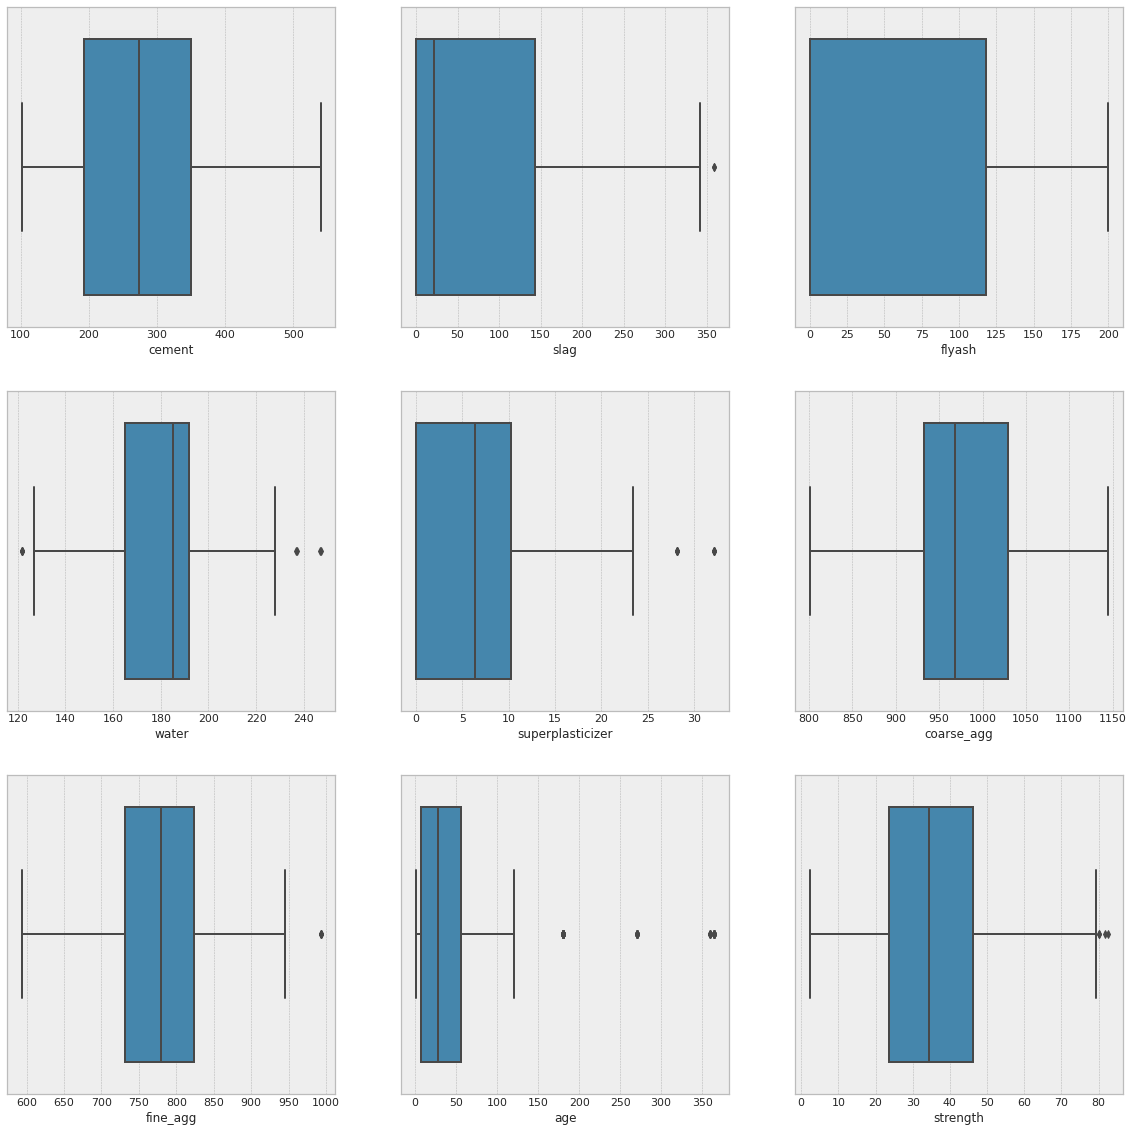

In [6]:
fig, axes = plt.subplots(3, 3, figsize = (20,20));
col_cnt = 0
col_names = df.columns.tolist()
for r in range(3):
    for c in range(3):
        try:
            sns.boxplot(df[col_names[col_cnt]], ax=axes[r][c], orient="h");
            col_cnt += 1
        except:
            pass

There are a few outliers in **slag**, **water**, **superplasticizer**, **fine_agg** and **age**. 

Removing the rows with outliers removes around 10% of the data so we will substitute them with the mean values.

In [7]:
outlier_cols = ["slag", "water", "superplasticizer", "fine_agg", "age"]
def cap_outliers(df, col):
    q1 = df_summary[col].loc["25%"]
    q3 = df_summary[col].loc["75%"]
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df.loc[df[col] < lower_bound, col] = df_summary[col].loc["mean"]
    df.loc[df[col] > upper_bound, col] = df_summary[col].loc["mean"]
    return df
    
    
for col in outlier_cols:
    df = cap_outliers(df, col)

## Multivariate analysis

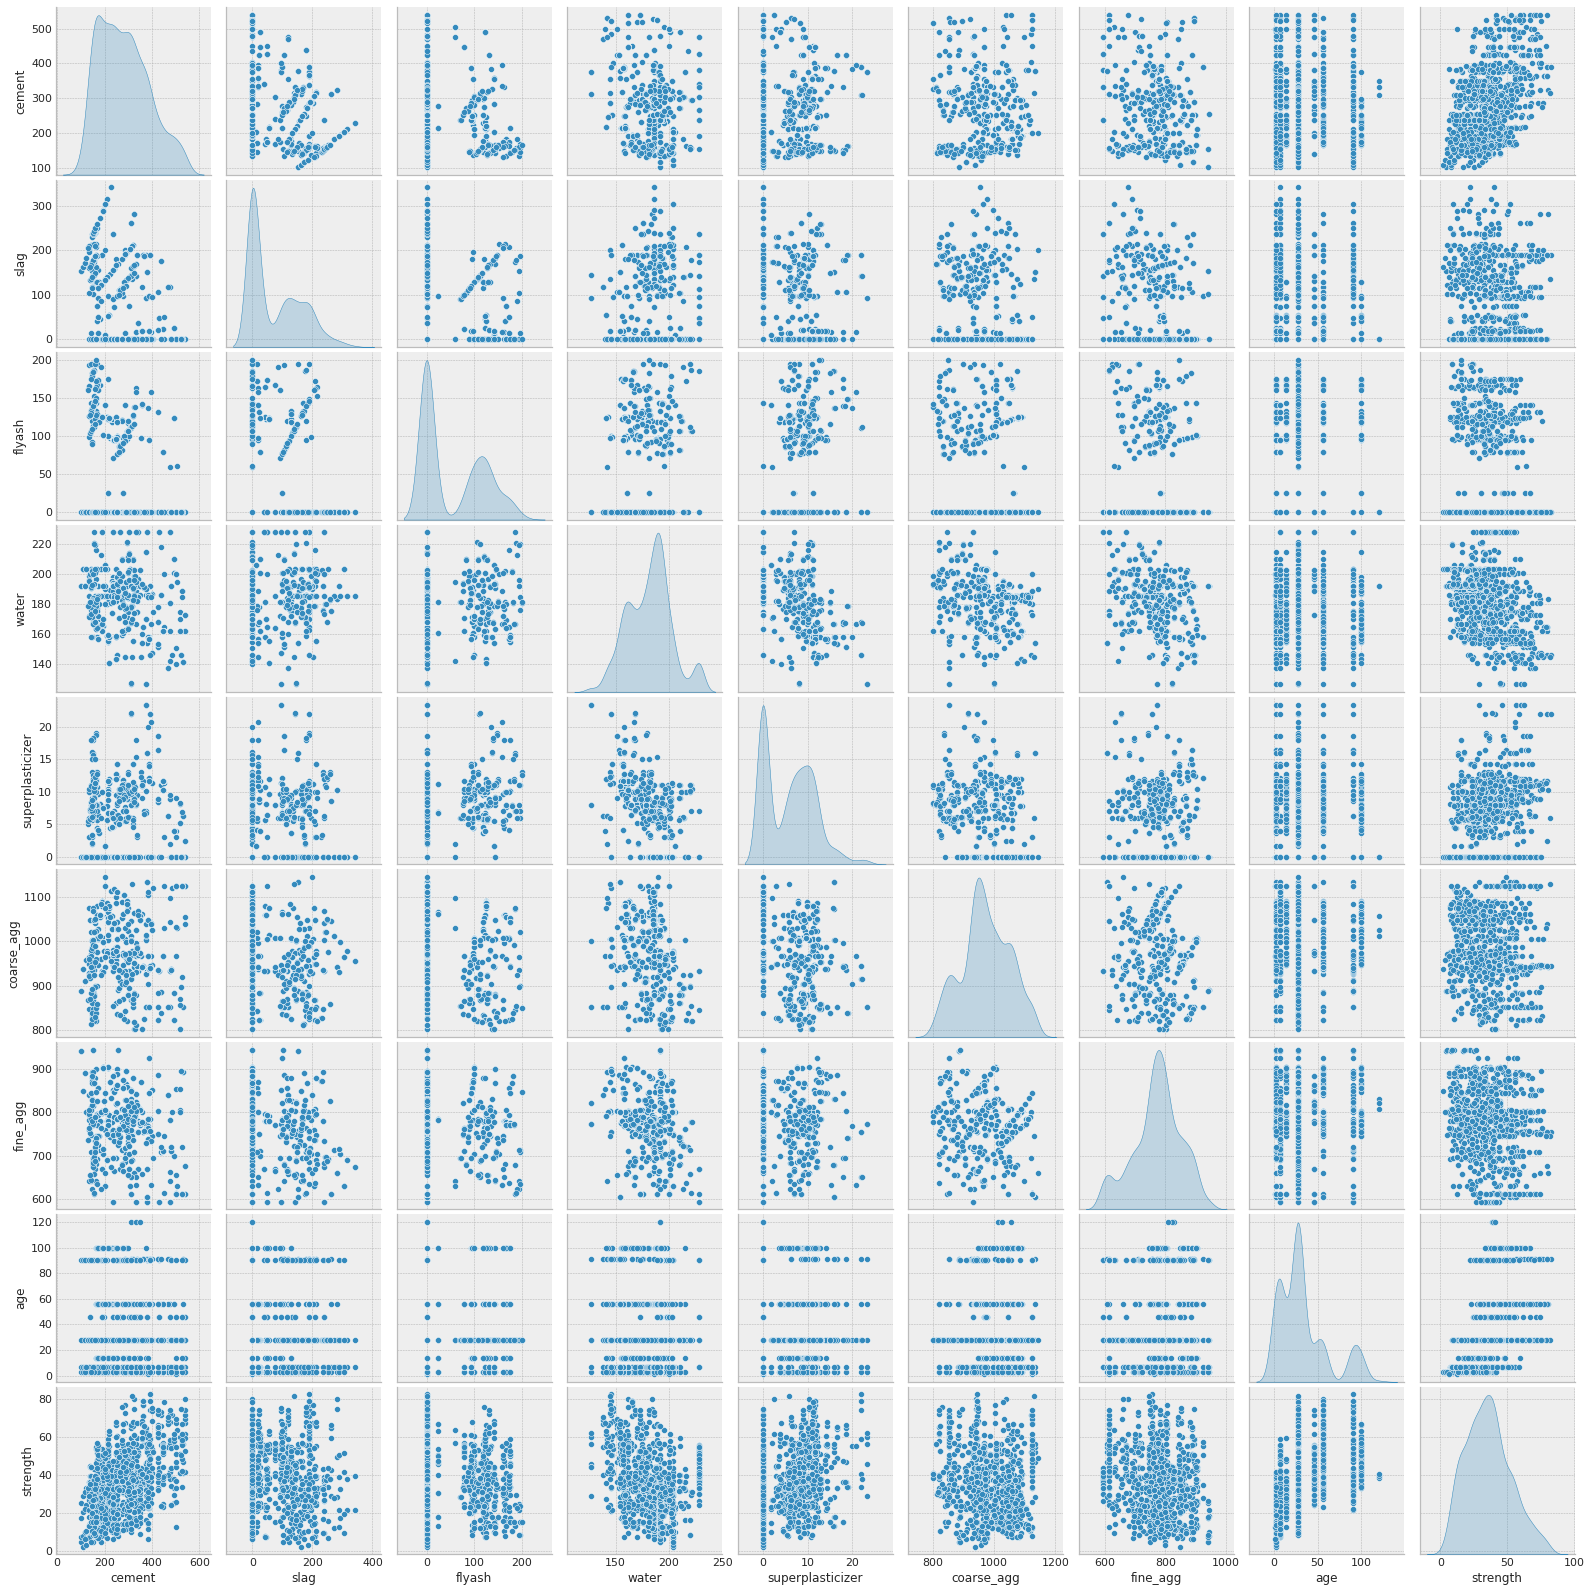

In [8]:
sns.pairplot(df, diag_kind="kde");

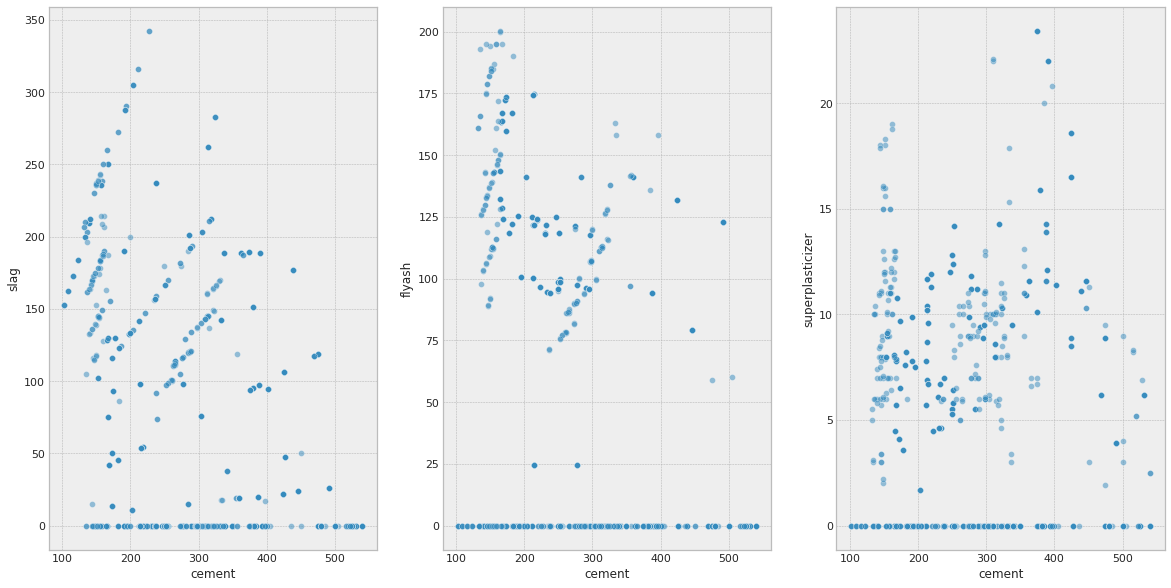

In [9]:
fig, axes = plt.subplots(1, 3, figsize = (20,10));

sns.scatterplot(y="slag", x="cement", data=df, ax=axes[0], alpha=0.5);
sns.scatterplot(y="flyash", x="cement", data=df, ax=axes[1], alpha=0.5);
sns.scatterplot(y="superplasticizer", x="cement", data=df, ax=axes[2], alpha=0.5);

In the charts above, we see some sort of pattern in the data and a lot of columns with zero values. We shall impute them using Linear Regression by considering other features to predict them.

**Observations:**

* As the amount of cement increases, the amount of slag does too. A pattern is visible in the first chart.
* If we look at the cement vs flyash closely, we can see pattern with a negative slope, the amount of cement is inversely proportional to the amount of flyash.
* The cement vs superplasticizer trend is similar to that of cement vs slag.

### Perform necessary imputation

In [10]:
def impute_values(alg, df, a, cols):
    df[a] = df[a].replace({0: np.nan})
    df_notnull = df[df[a].notna()]
    
    X = df_notnull[cols]
    y = df_notnull[a]
    
    df_null = df[df[a].isna()]
    test_X = df_null[cols]

    regr = alg
    regr.fit(X, y)

    pred = regr.predict(test_X)
    df_null = df[df[a].isna()]
    df_null[a] = pred
    
    xx = df[df[a].notna()]
    xx["null"] = 0
    df_null["null"] = 1
    df = pd.concat([xx, df_null], axis=0)
    cols.append(a)
    return df

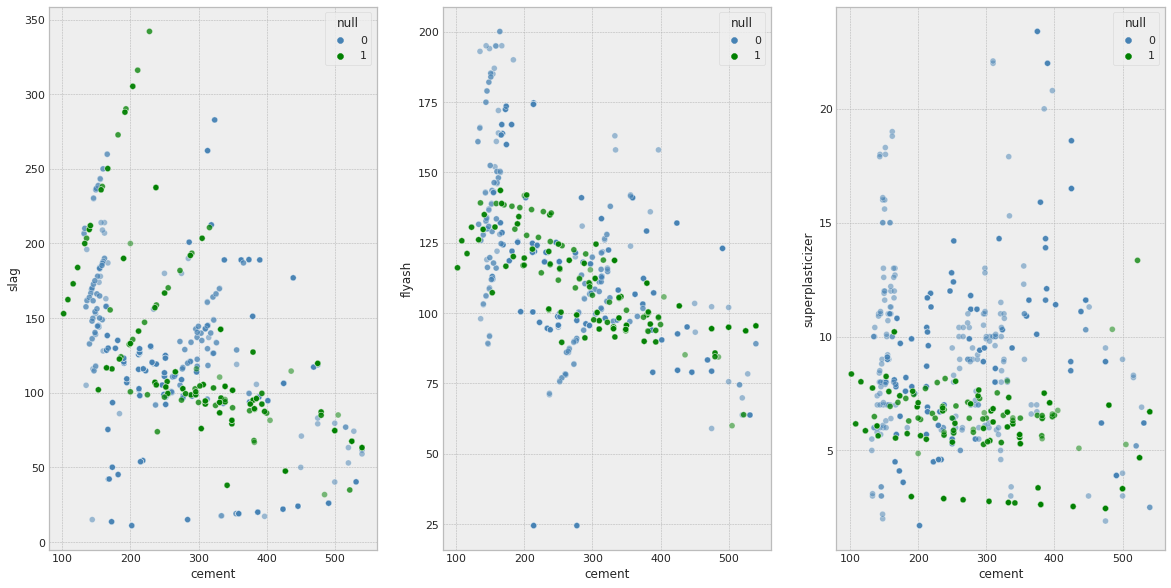

In [11]:
for col, params in {"flyash": ["cement", "water", "fine_agg"], "slag": ["cement", "coarse_agg", "fine_agg"], "superplasticizer" : ["cement", "water", "coarse_agg"]}.items():
    alg = LinearRegression()
    df = impute_values(alg, df, col, params)
    
fig, axes = plt.subplots(1, 3, figsize = (20,10));

sns.scatterplot(y="slag", x="cement", data=df, hue="null", ax=axes[0], alpha=0.5, palette=["steelblue", "green"]);
sns.scatterplot(y="flyash", x="cement", data=df, hue="null", ax=axes[1], alpha=0.5, palette=["steelblue", "green"]);
sns.scatterplot(y="superplasticizer", x="cement", data=df, hue="null", ax=axes[2], alpha=0.5, palette=["steelblue", "green"]);
plt.show()

The above plot shows the zero values imputed in green and the rest in blue. Looks like our imputed values fit the patterns.

In [12]:
df.drop(columns=["null"], inplace=True)

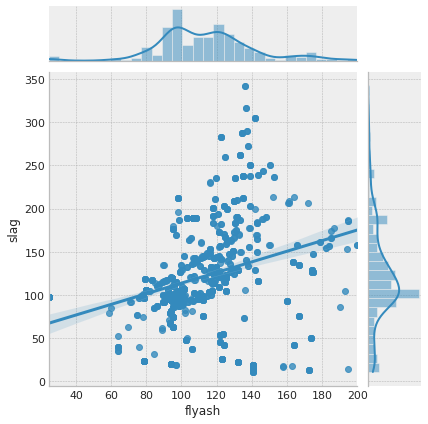

In [13]:
sns.jointplot(x="flyash", y="slag", data=df[["flyash", "slag"]], kind="reg");

For some of the data points in the above plot, there seems to be a direct correlation between the amount of slag and flyash with a slope of almost equal to 0.8 which is quite high. Amount of slag increases with increase in flyash.

# Feature engineering

### Creating composite features

We can create 2 composite features using **cement** - **water** and **coarse_agg** - **fine_agg**

In [14]:
df_copy = df.copy()
df_copy["cement_water_ratio"] = df_copy["cement"]/df_copy["water"]
df_copy["average_agg"] = (df_copy["coarse_agg"] + df_copy["fine_agg"])/2
df_copy.drop(columns=["cement", "water", "coarse_agg", "fine_agg"], inplace=True)

In [15]:
target_col = ["strength"]
col_names = df_copy.columns.to_list()
col_names.remove(target_col[0])

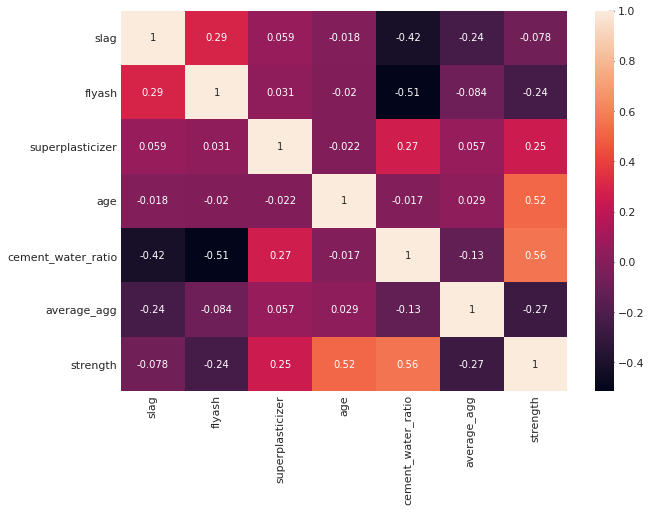

In [16]:
plt.figure(figsize=(10,7))
sns.heatmap(df_copy[col_names + target_col].corr(), fmt=".2g", annot=True);

* It looks like our composite feature **cement_water_ratio** and **flyash** are negatively correlated. 
* The target column **strength** has good amount of correlation with **age** and **cement_water_ratio**.

### Explore for Gaussians

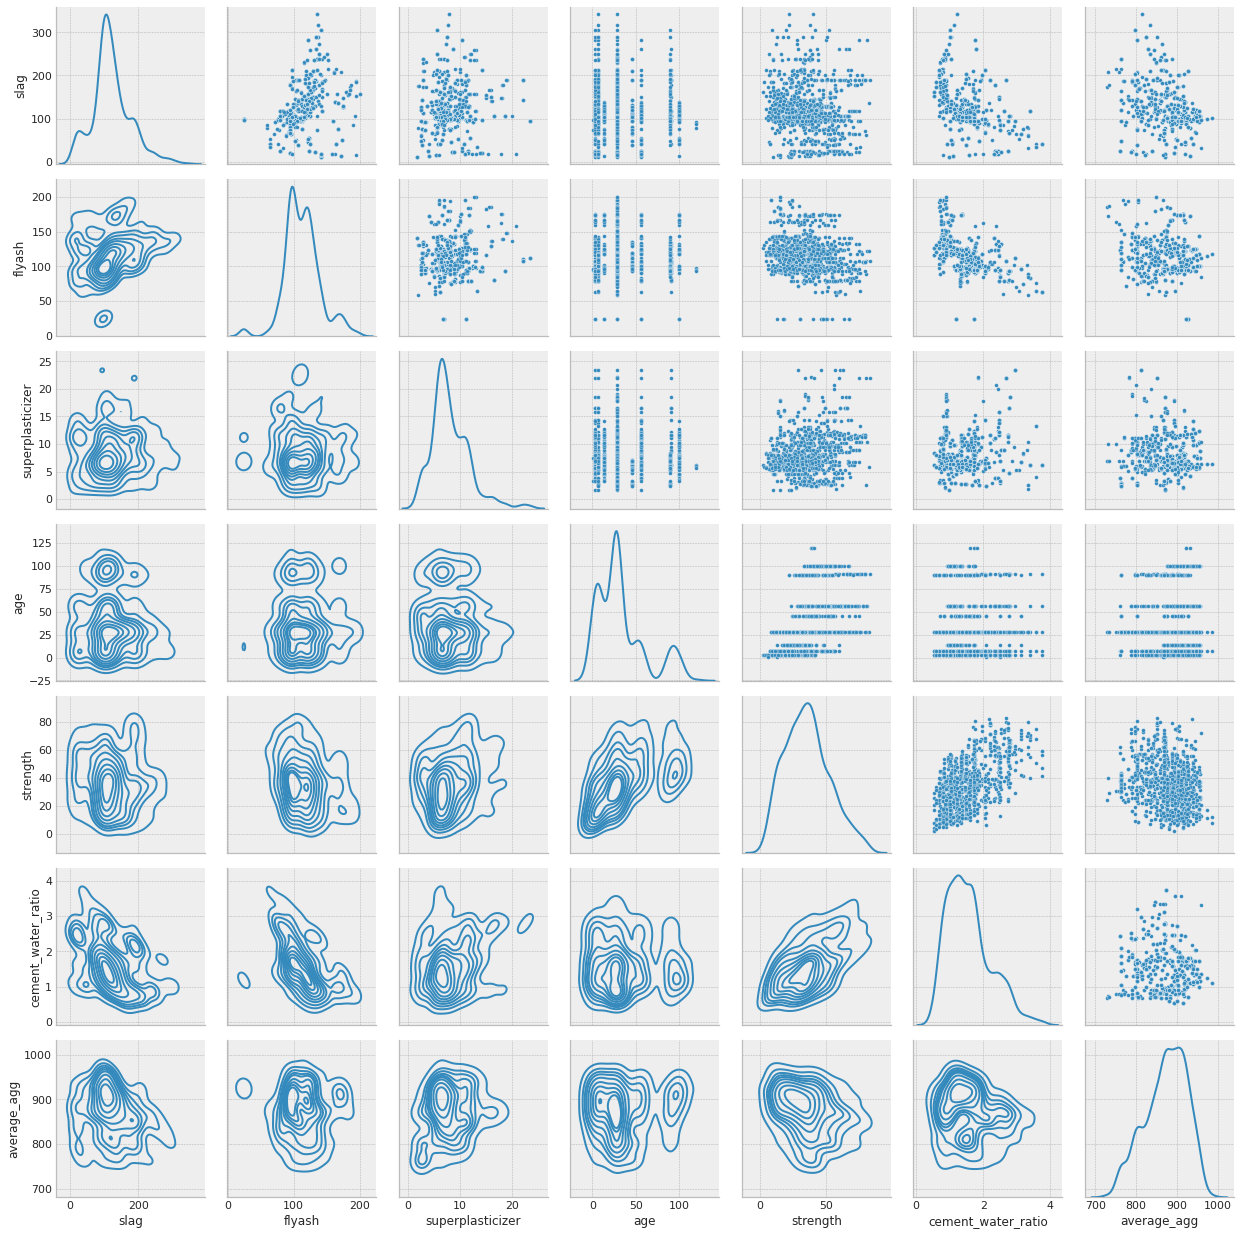

In [17]:
g = sns.PairGrid(df_copy, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

* Looking at the kdeplots of strength vs other independent columns, we can see that the data is infact a mixture of Gaussians.

* Strength vs flyash shows us two distinct Gaussians and 2 clusters but looking at the position of the two clusters, it might not be very helpful in determining/predicting the strength and the same goes for Strength vs superplasticizer.

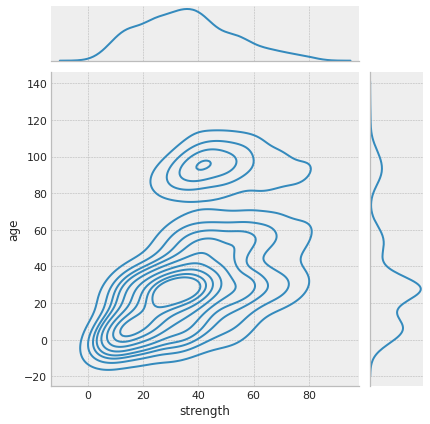

In [18]:
sns.jointplot(x="strength", y="age", data=df_copy[["age", "strength"]], kind="kde");

* Strength vs age is very interesting to look at. We can clearly see four clusters, 2 big ones and 2 tiny. We can also see that as the age increases, the strength increases too so this might be a helpful feature in predicting the Strength. There is one cluster that is far away from the rest of the clusters. It could mean that the concrete that has an age range of 80-100 has average strength.

* We will check if it really works by creating a KNeighbors Regressor model.

## Create the models

In [19]:
# Prepare data for training

X = df_copy[col_names]    # Contains the independent columns 
y = df_copy[target_col]     # Our target column

seed = 16
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = seed)
train_X_poly, train_y_poly, test_X_poly, test_y_poly = (None,) * 4
train_y = train_y[target_col[0]]
test_y = test_y[target_col[0]]

In [20]:
evaluation = {"Metrics" : ['Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'R2 score', 'CV-mean']}
def evaluate_model(name, train_X, train_y, test_X, test_y, types, alg, plot=True):
    global evaluation, pred
    
    alg.fit(train_X, train_y)
    print(f"Score: {alg.score(test_X, test_y)}")
    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(20, 10))
        try:
            if types == "Coefs":
                print(f"Intercept: {alg.intercept_}")
                try:
                    coefs = pd.DataFrame({"coefs" : alg.coef_, "col" : col_names})
                except:
                    coefs = pd.DataFrame({"coefs" : alg.coef_[0], "col" : col_names})
                sns.barplot(x="col", y="coefs", data=coefs, ax=axes[1]);
            else:
                features = pd.DataFrame({"features" : alg.feature_importances_, "col" : col_names})
                sns.barplot(x="col", y="features", data=features, ax=axes[1]);
        except:
            pass
    else:
        plt.figure(figsize=(20,5));
        axes = [None]

    pred = alg.predict(test_X)
    rmsecm = np.sqrt(metrics.mean_squared_error(test_y,pred))
    mae = mean_absolute_error(test_y, pred)
    mse = mean_squared_error(test_y, pred)
    r2 = r2_score(test_y, pred)

    p = pd.DataFrame(pred, columns=[0])
    p["Type"] = "Predictions"
    p["n"] = list(range(p.shape[0]))
    t = test_y.copy()
    t = t.reset_index().set_index("index")
    t.columns = [0]
    t["Type"] = "Actual"
    t = t[t[0] != "Actual"]
    t["n"] = list(range(p.shape[0]))
    x = pd.concat([p,t], axis=0).reset_index()
    sns.lineplot(x="n", y=0, hue="Type", data=x, markers=["o", "o"], style="Type", ax=axes[0]);
    
    cv = cross_val_score(alg, X, y, cv=10)
    cv_mean = cv.ravel().mean()
    
    evaluation[name] = [rmsecm, mae, mse, r2, cv_mean]
    df_ev = pd.DataFrame(evaluation)
    plt.show()
    return df_ev, cv

### Multiple linear regression

Score: 0.6743969685479323
Intercept: 55.997491712431774


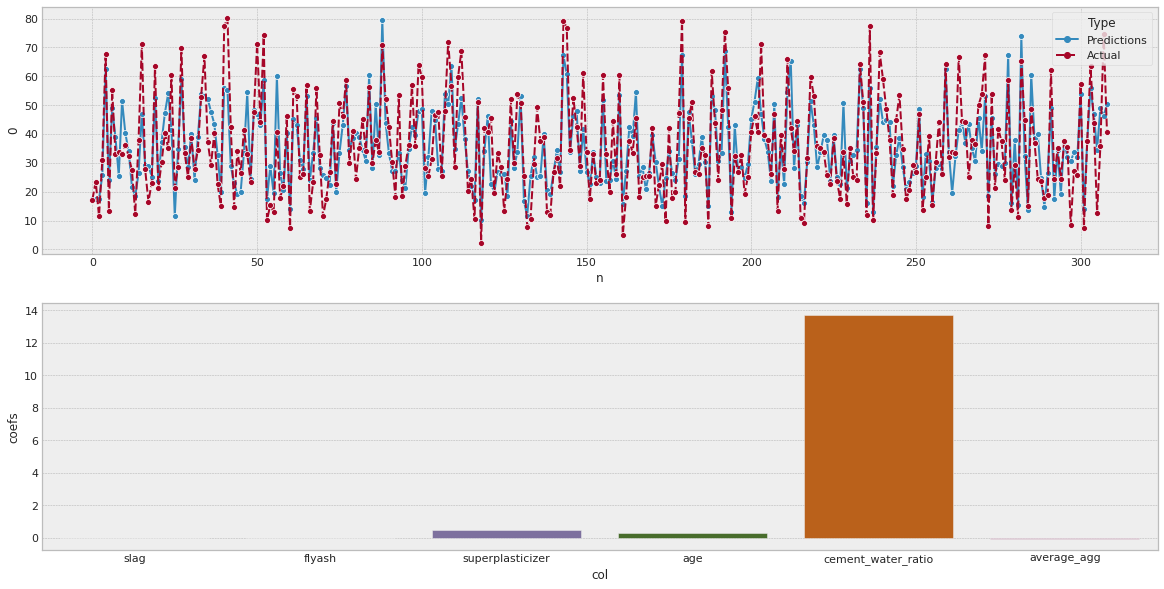

Multiple Regression
Metrics                                            
Root Mean Squared Error (RMSE)             9.851294
Mean Absolute Error (MAE)                  7.762884
Mean Squared Error (MSE)                  97.047988
R2 score                                   0.674397
CV-mean                                    0.495709

In [21]:
lr = linear_model.LinearRegression()
evaluation, cv_scores = evaluate_model("Multiple Regression", train_X, train_y, test_X, test_y, "Coefs", lr)
evaluation.set_index("Metrics")

The column **cement_water_ratio** has the highest coefficient value than the rest of the features which means it has the highest weight in the prediction of the **strength** column.

___________

[0.07738547 0.65056056 0.40807195 0.68206926 0.72555453 0.5271538
 0.38286732 0.6496494  0.28873574 0.56503903]
Average score: 50.0%


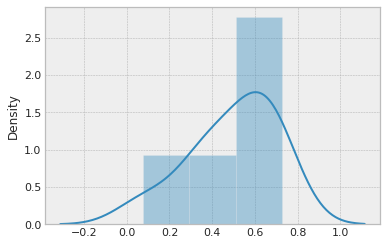

In [22]:
print(cv_scores)
sns.distplot(cv_scores);
print(f"Average score: {round(cv_scores.mean(),2)*100}%")

### Ridge regressor

Score: 0.6739599292209226
Intercept: 56.56665226289299


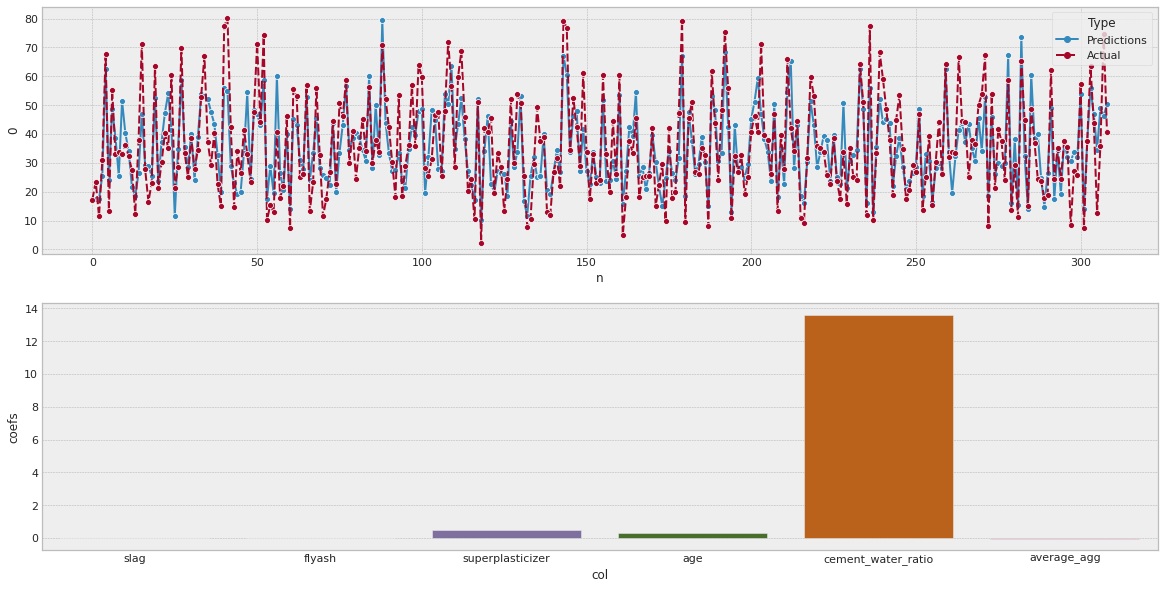

Multiple Regression      Ridge
Metrics                                                       
Root Mean Squared Error (RMSE)             9.851294   9.857903
Mean Absolute Error (MAE)                  7.762884   7.767533
Mean Squared Error (MSE)                  97.047988  97.178251
R2 score                                   0.674397   0.673960
CV-mean                                    0.495709   0.495964

In [23]:
rg = linear_model.Ridge()
evaluation, cv_scores = evaluate_model("Ridge", train_X, train_y, test_X, test_y, "Coefs", rg)
evaluation.set_index("Metrics")

The column **cement_water_ratio** has the highest coefficient value than the rest of the features which means it has the highest weight in the prediction of the **strength** column.

___________

## Decide on complexity of the model

### Polynomial regression

Score: 0.8210418168938123


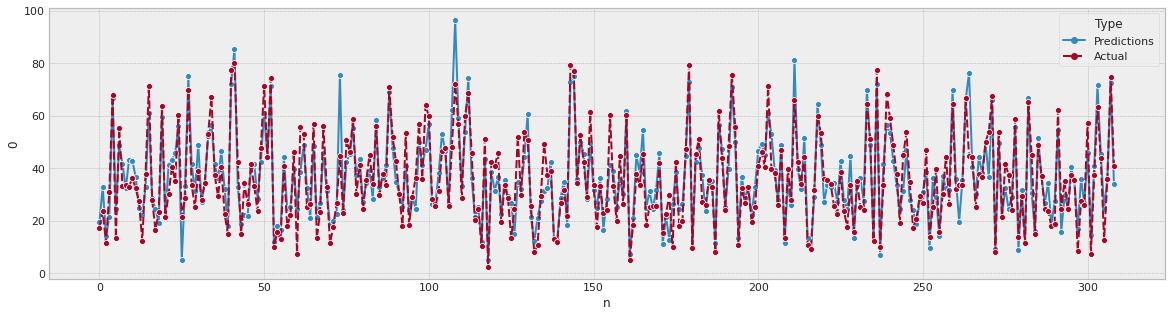

Multiple Regression      Ridge  \
Metrics                                                          
Root Mean Squared Error (RMSE)             9.851294   9.857903   
Mean Absolute Error (MAE)                  7.762884   7.767533   
Mean Squared Error (MSE)                  97.047988  97.178251   
R2 score                                   0.674397   0.673960   
CV-mean                                    0.495709   0.495964   

                                Polynomial Regression  
Metrics                                                
Root Mean Squared Error (RMSE)               7.303396  
Mean Absolute Error (MAE)                    5.612208  
Mean Squared Error (MSE)                    53.339588  
R2 score                                     0.821042  
CV-mean                                      0.495709

In [24]:
# Fitting Polynomial Regression to the dataset

poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X)

train_X_poly, test_X_poly, train_y_poly, test_y_poly = train_test_split(X_poly, y, test_size = 0.3, random_state = seed)
train_y_poly = train_y_poly[target_col[0]]
test_y_poly = test_y_poly[target_col[0]]

plr = LinearRegression()
evaluation, cv_scores = evaluate_model("Polynomial Regression", train_X_poly, train_y_poly, test_X_poly, test_y_poly,  "Coefs", plr, plot=False)
evaluation.set_index("Metrics")

[0.07738547 0.65056056 0.40807195 0.68206926 0.72555453 0.5271538
 0.38286732 0.6496494  0.28873574 0.56503903]
Average score: 50.0%


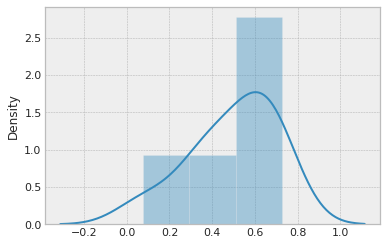

In [25]:
print(cv_scores)
sns.distplot(cv_scores);
print(f"Average score: {round(cv_scores.mean(),2)*100}%")

##### Looking at the cross validation scores of both Multiple linear regressor and Polynomial regressor with parameter of higher degrees, they are exactly the same so we don't really need a complex model. Also, looking at the coefficients, it looks like the strength can be calculated with a simple linear equation using these coefficients (meaning it is made up simple proportions of the other features). 
##### On a separate not, it doesn't give us any extra accuracy, instead increases complexity and time required to give the same results.

___________

## Support Vector Regressor

Score: 0.6302657750909102
Intercept: [70.687924]


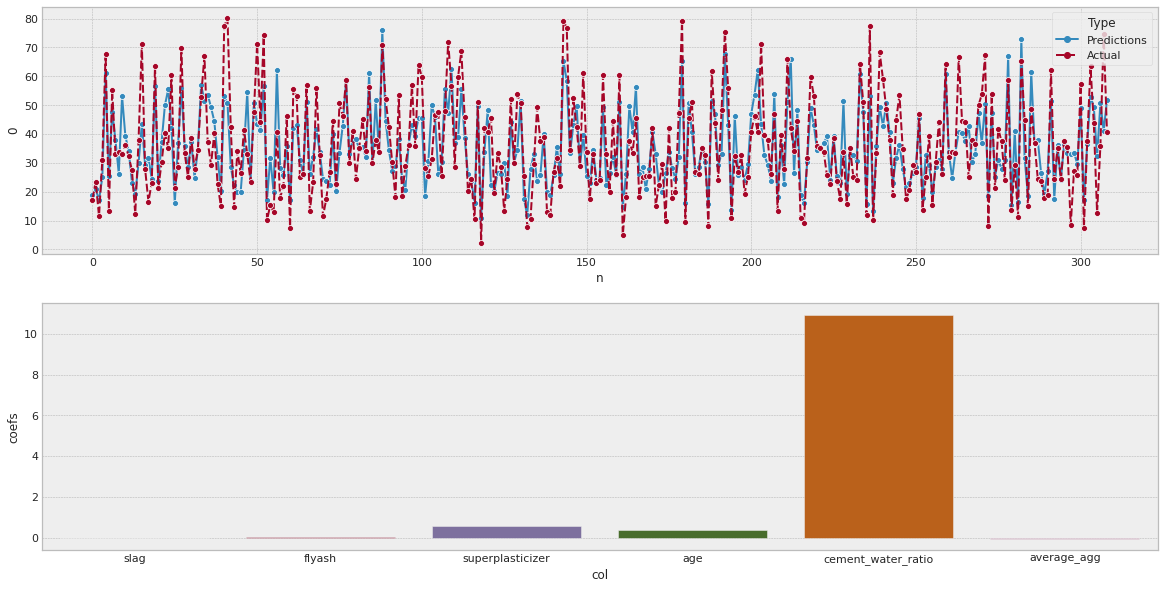

Multiple Regression      Ridge  \
Metrics                                                          
Root Mean Squared Error (RMSE)             9.851294   9.857903   
Mean Absolute Error (MAE)                  7.762884   7.767533   
Mean Squared Error (MSE)                  97.047988  97.178251   
R2 score                                   0.674397   0.673960   
CV-mean                                    0.495709   0.495964   

                                Polynomial Regression  \
Metrics                                                 
Root Mean Squared Error (RMSE)               7.303396   
Mean Absolute Error (MAE)                    5.612208   
Mean Squared Error (MSE)                    53.339588   
R2 score                                     0.821042   
CV-mean                                      0.495709   

                                Support Vector Regression  
Metrics                                                    
Root Mean Squared Error (RMSE)                  10.497693  
Mean Absolute Error (MAE)                        8.149601  
Mean Squared Error (MSE)                       110.201562  
R2 score                                         0.630266  
CV-mean                                          0.465583

In [26]:
svr = SVR(C=10, kernel="linear")
evaluation, cv_scores = evaluate_model("Support Vector Regression", train_X, train_y, test_X, test_y, "Coefs", svr)
evaluation.set_index("Metrics")

Score: 0.7198041267557937


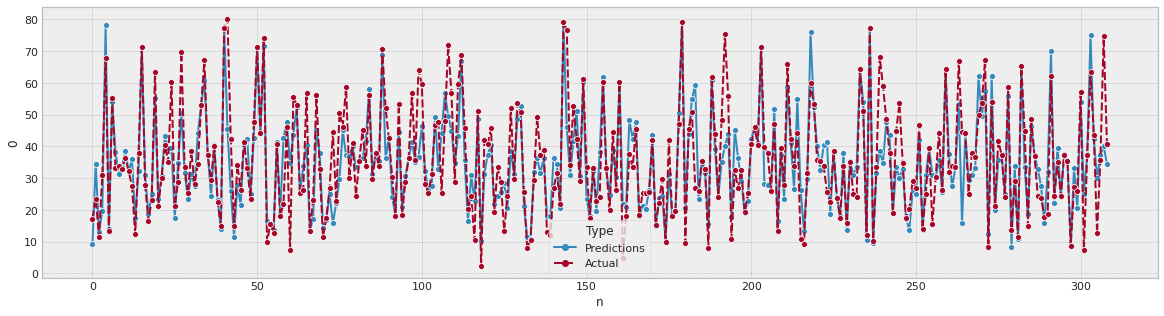

Multiple Regression      Ridge  \
Metrics                                                          
Root Mean Squared Error (RMSE)             9.851294   9.857903   
Mean Absolute Error (MAE)                  7.762884   7.767533   
Mean Squared Error (MSE)                  97.047988  97.178251   
R2 score                                   0.674397   0.673960   
CV-mean                                    0.495709   0.495964   

                                Polynomial Regression  \
Metrics                                                 
Root Mean Squared Error (RMSE)               7.303396   
Mean Absolute Error (MAE)                    5.612208   
Mean Squared Error (MSE)                    53.339588   
R2 score                                     0.821042   
CV-mean                                      0.495709   

                                Support Vector Regression        KNN  
Metrics                                                               
Root Mean Squared Error (RMSE)                  10.497693   9.138605  
Mean Absolute Error (MAE)                        8.149601   5.930828  
Mean Squared Error (MSE)                       110.201562  83.514105  
R2 score                                         0.630266   0.719804  
CV-mean                                          0.465583   0.310515

In [27]:
knn = KNeighborsRegressor(n_neighbors=4, metric="manhattan", weights="distance")
evaluation, cv_scores = evaluate_model("KNN", train_X, train_y, test_X, test_y, "Coefs", knn, plot=False)
evaluation.set_index("Metrics")

Score: 0.8037257895269719


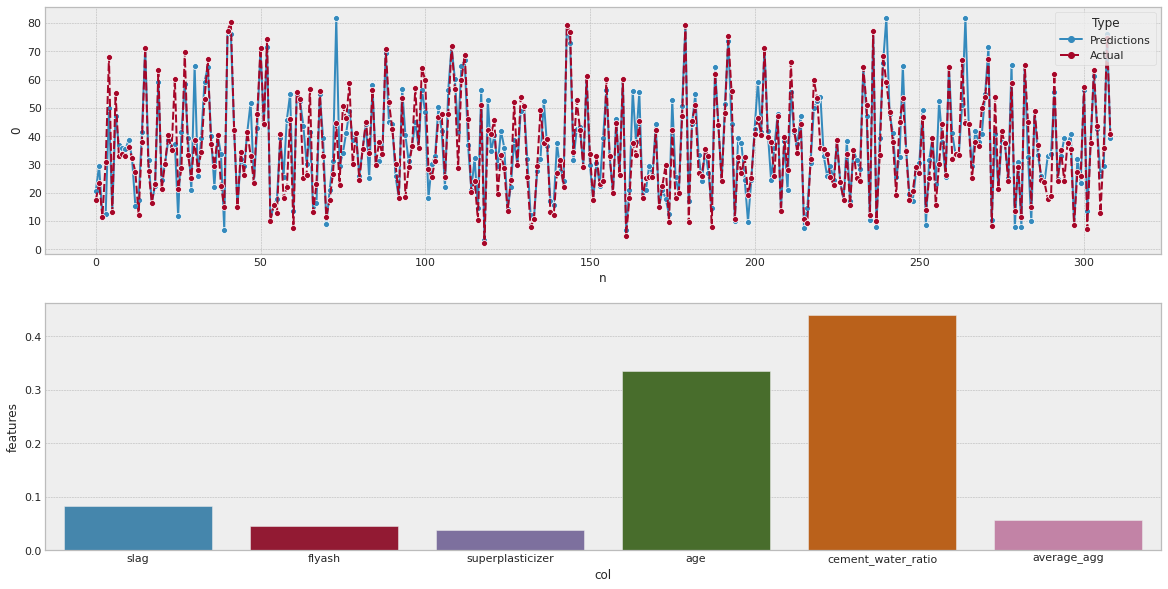

Multiple Regression      Ridge  \
Metrics                                                          
Root Mean Squared Error (RMSE)             9.851294   9.857903   
Mean Absolute Error (MAE)                  7.762884   7.767533   
Mean Squared Error (MSE)                  97.047988  97.178251   
R2 score                                   0.674397   0.673960   
CV-mean                                    0.495709   0.495964   

                                Polynomial Regression  \
Metrics                                                 
Root Mean Squared Error (RMSE)               7.303396   
Mean Absolute Error (MAE)                    5.612208   
Mean Squared Error (MSE)                    53.339588   
R2 score                                     0.821042   
CV-mean                                      0.495709   

                                Support Vector Regression        KNN  \
Metrics                                                                
Root Mean Squared Error (RMSE)                  10.497693   9.138605   
Mean Absolute Error (MAE)                        8.149601   5.930828   
Mean Squared Error (MSE)                       110.201562  83.514105   
R2 score                                         0.630266   0.719804   
CV-mean                                          0.465583   0.310515   

                                Decision Tree Regression  
Metrics                                                   
Root Mean Squared Error (RMSE)                  7.648577  
Mean Absolute Error (MAE)                       5.001327  
Mean Squared Error (MSE)                       58.500737  
R2 score                                        0.803726  
CV-mean                                         0.476731

In [28]:
dtr = DecisionTreeRegressor()
evaluation, cv_scores = evaluate_model("Decision Tree Regression", train_X, train_y, test_X, test_y, "Features", dtr)
evaluation.set_index("Metrics")

It is clearly visible that the feature that have the most importance are the **cement_water_ratio** and **age** in predicting the **strength**.

___________

Score: 0.89742702338288


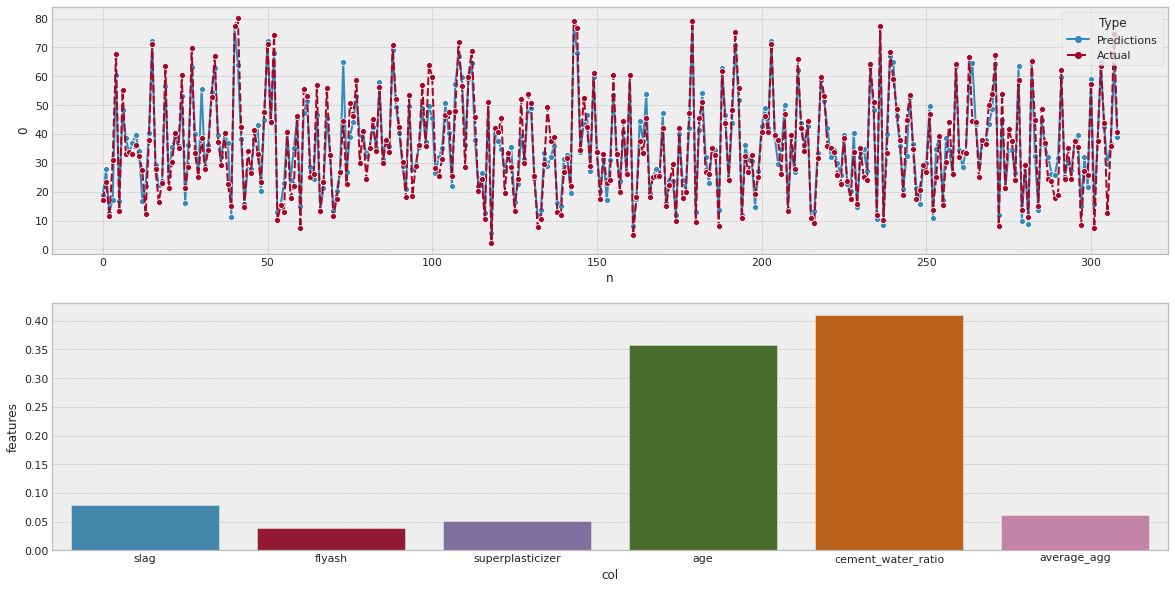

Multiple Regression      Ridge  \
Metrics                                                          
Root Mean Squared Error (RMSE)             9.851294   9.857903   
Mean Absolute Error (MAE)                  7.762884   7.767533   
Mean Squared Error (MSE)                  97.047988  97.178251   
R2 score                                   0.674397   0.673960   
CV-mean                                    0.495709   0.495964   

                                Polynomial Regression  \
Metrics                                                 
Root Mean Squared Error (RMSE)               7.303396   
Mean Absolute Error (MAE)                    5.612208   
Mean Squared Error (MSE)                    53.339588   
R2 score                                     0.821042   
CV-mean                                      0.495709   

                                Support Vector Regression        KNN  \
Metrics                                                                
Root Mean Squared Error (RMSE)                  10.497693   9.138605   
Mean Absolute Error (MAE)                        8.149601   5.930828   
Mean Squared Error (MSE)                       110.201562  83.514105   
R2 score                                         0.630266   0.719804   
CV-mean                                          0.465583   0.310515   

                                Decision Tree Regression  \
Metrics                                                    
Root Mean Squared Error (RMSE)                  7.648577   
Mean Absolute Error (MAE)                       5.001327   
Mean Squared Error (MSE)                       58.500737   
R2 score                                        0.803726   
CV-mean                                         0.476731   

                                Random Forest Regression  
Metrics                                                   
Root Mean Squared Error (RMSE)                  5.529241  
Mean Absolute Error (MAE)                       4.014275  
Mean Squared Error (MSE)                       30.572507  
R2 score                                        0.897427  
CV-mean                                         0.693154

In [29]:
rfr = RandomForestRegressor()
evaluation, cv_scores = evaluate_model("Random Forest Regression", train_X, train_y, test_X, test_y, "Features", rfr)
evaluation.set_index("Metrics")

It is clearly visible that the feature that have the most importance are the **cement_water_ratio** and **age** in predicting the **strength**.

___________

Score: 0.9221087694583838


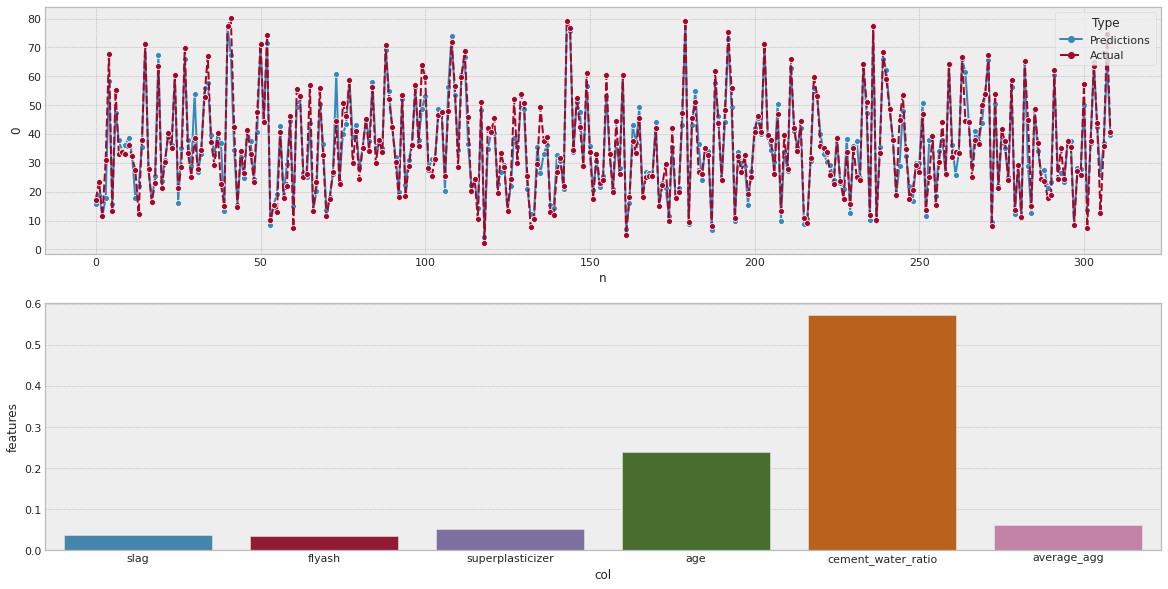

Multiple Regression      Ridge  \
Metrics                                                          
Root Mean Squared Error (RMSE)             9.851294   9.857903   
Mean Absolute Error (MAE)                  7.762884   7.767533   
Mean Squared Error (MSE)                  97.047988  97.178251   
R2 score                                   0.674397   0.673960   
CV-mean                                    0.495709   0.495964   

                                Polynomial Regression  \
Metrics                                                 
Root Mean Squared Error (RMSE)               7.303396   
Mean Absolute Error (MAE)                    5.612208   
Mean Squared Error (MSE)                    53.339588   
R2 score                                     0.821042   
CV-mean                                      0.495709   

                                Support Vector Regression        KNN  \
Metrics                                                                
Root Mean Squared Error (RMSE)                  10.497693   9.138605   
Mean Absolute Error (MAE)                        8.149601   5.930828   
Mean Squared Error (MSE)                       110.201562  83.514105   
R2 score                                         0.630266   0.719804   
CV-mean                                          0.465583   0.310515   

                                Decision Tree Regression  \
Metrics                                                    
Root Mean Squared Error (RMSE)                  7.648577   
Mean Absolute Error (MAE)                       5.001327   
Mean Squared Error (MSE)                       58.500737   
R2 score                                        0.803726   
CV-mean                                         0.476731   

                                Random Forest Regression    XGBoost  
Metrics                                                              
Root Mean Squared Error (RMSE)                  5.529241   4.818294  
Mean Absolute Error (MAE)                       4.014275   3.243803  
Mean Squared Error (MSE)                       30.572507  23.215961  
R2 score                                        0.897427   0.922109  
CV-mean                                         0.693154   0.692599

In [30]:
xgc = XGBRegressor()
evaluation, cv_scores = evaluate_model("XGBoost", train_X, train_y, test_X, test_y, "Features", xgc)
evaluation.set_index("Metrics")

It is clearly visible that the feature that have the most importance are the **cement_water_ratio** and **age** in predicting the **strength**. Though **age** has almost half the importance as **cement_water_ratio**.

___________

#### Let's make use of GridSearchCV to find the right set of parameters for our model

In [31]:
model = XGBRegressor(n_jobs=4)

parameters = {
    'n_estimators': [50, 100, 500],
    'max_depth': [2, 4, 6, 8, 10],
    'gamma': [0.001, 0.01],
    'learning_rate': [0.01, 0.1],
    'booster': ['gbtree']
}

grid_obj = GridSearchCV(
    estimator=xgc,
    param_grid=parameters
)

grid_obj.fit(X, y)

best_model = grid_obj.best_estimator_
print(best_model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


Score: 0.9329116320508589


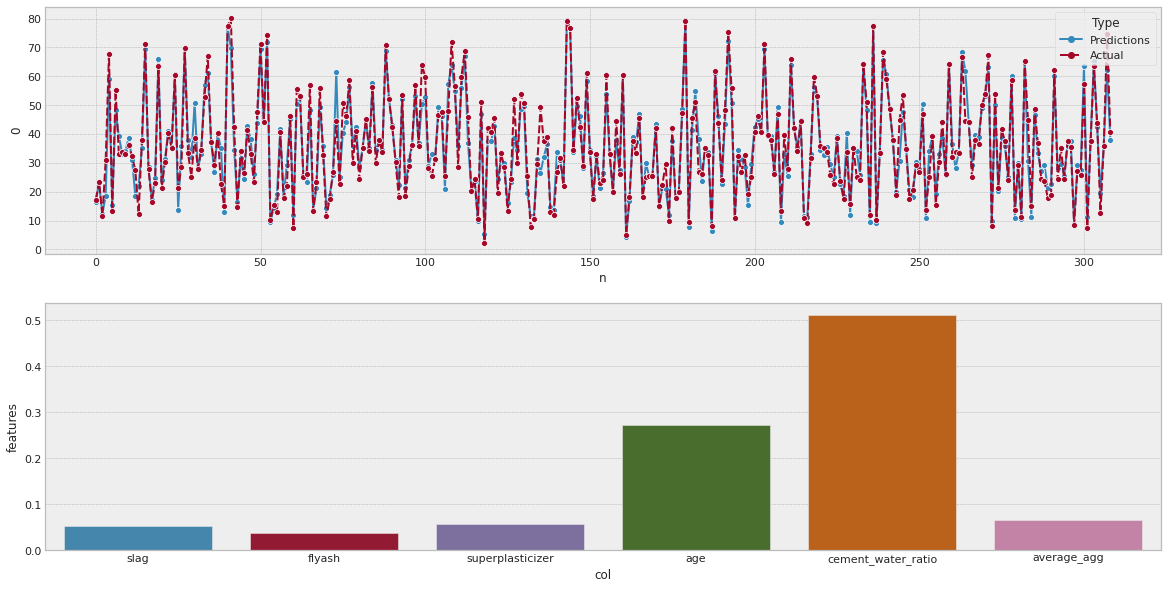

Multiple Regression      Ridge  \
Metrics                                                          
Root Mean Squared Error (RMSE)             9.851294   9.857903   
Mean Absolute Error (MAE)                  7.762884   7.767533   
Mean Squared Error (MSE)                  97.047988  97.178251   
R2 score                                   0.674397   0.673960   
CV-mean                                    0.495709   0.495964   

                                Polynomial Regression  \
Metrics                                                 
Root Mean Squared Error (RMSE)               7.303396   
Mean Absolute Error (MAE)                    5.612208   
Mean Squared Error (MSE)                    53.339588   
R2 score                                     0.821042   
CV-mean                                      0.495709   

                                Support Vector Regression        KNN  \
Metrics                                                                
Root Mean Squared Error (RMSE)                  10.497693   9.138605   
Mean Absolute Error (MAE)                        8.149601   5.930828   
Mean Squared Error (MSE)                       110.201562  83.514105   
R2 score                                         0.630266   0.719804   
CV-mean                                          0.465583   0.310515   

                                Decision Tree Regression  \
Metrics                                                    
Root Mean Squared Error (RMSE)                  7.648577   
Mean Absolute Error (MAE)                       5.001327   
Mean Squared Error (MSE)                       58.500737   
R2 score                                        0.803726   
CV-mean                                         0.476731   

                                Random Forest Regression    XGBoost  \
Metrics                                                               
Root Mean Squared Error (RMSE)                  5.529241   4.818294   
Mean Absolute Error (MAE)                       4.014275   3.243803   
Mean Squared Error (MSE)                       30.572507  23.215961   
R2 score                                        0.897427   0.922109   
CV-mean                                         0.693154   0.692599   

                                XGBoost Tuned  
Metrics                                        
Root Mean Squared Error (RMSE)       4.471700  
Mean Absolute Error (MAE)            3.037378  
Mean Squared Error (MSE)            19.996101  
R2 score                             0.932912  
CV-mean                              0.694881

In [32]:
xgc = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
evaluation, cv_scores =  evaluate_model("XGBoost Tuned", train_X, train_y, test_X, test_y, "Features", xgc)
evaluation.set_index("Metrics")

Please consider upvoting if you found this useful and informative. Thank you.